In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 
import os 
import pickle 
from scipy.spatial.transform import Rotation as R 
from scipy.spatial import KDTree 
import time 

In [2]:
# pose transformation functions 
# TODO: clean up and consolidate functions 

# convert pose to transformation matrix 
def pose2transform(pose):
    if pose.ndim == 1:
        if pose.shape[0] == 6: 
            T = np.eye(4) 
            # T[:3, :3] = R.from_euler('xyz', pose[3:], degrees=True).as_matrix() 
            T[:3, :3] = R.from_euler('ZYX', pose[3:], degrees=True).as_matrix() 
            T[:3, 3] = pose[:3] 
            return T 
        elif pose.shape[0] == 7: 
            T = np.eye(4) 
            T[:3, :3] = R.from_quat(pose[3:], scalar_first=True).as_matrix() 
            T[:3, 3] = pose[:3] 
            return T 
    else: 
        if pose.shape[1] == 6: 
            T = np.zeros((pose.shape[0], 4, 4)) 
            for i in range(pose.shape[0]): 
                # T[i, :3, :3] = R.from_euler('xyz', pose[i, 3:], degrees=True).as_matrix() 
                T[i, :3, :3] = R.from_euler('ZYX', pose[i, 3:], degrees=True).as_matrix() 
                T[i, :3, 3] = pose[i, :3] 
            T[:, 3, 3] = 1 
            return T 
        elif pose.shape[1] == 7: 
            T = np.zeros((pose.shape[0], 4, 4)) 
            for i in range(pose.shape[0]): 
                T[i, :3, :3] = R.from_quat(pose[i, 3:], scalar_first=True).as_matrix() 
                T[i, :3, 3] = pose[i, :3] 
            T[:, 3, 3] = 1 
            return T 
        
def poses7D2poses6D(poses):
    if poses.ndim == 1: 
        poses6D = np.zeros(6) 
        poses6D[:3] = poses[:3] 
        # poses6D[3:] = R.from_quat(poses[3:], scalar_first=True).as_euler('xyz', degrees=True) 
        poses6D[3:] = R.from_quat(poses[3:], scalar_first=True).as_euler('ZYX', degrees=True) 
        return poses6D
    else:  
        poses6D = np.zeros((poses.shape[0], 6)) 
        for i in range(poses.shape[0]): 
            poses6D[i, :3] = poses[i, :3] 
            # poses6D[i, 3:] = R.from_quat(poses[i, 3:], scalar_first=True).as_euler('xyz', degrees=True) 
            poses6D[i, 3:] = R.from_quat(poses[i, 3:], scalar_first=True).as_euler('ZYX', degrees=True) 
        return poses6D 

# convert transformation matrix to pose 
def transform2pose(T):
    pose = np.zeros(7) 
    pose[:3] = T[:3, 3] 
    pose[3:] = R.from_matrix(T[:3, :3]).as_quat(scalar_first=True) 
    return pose 

def pose6D2transform(pose):
    T = np.eye(4) 
    # T[:3, :3] = R.from_euler('xyz', pose[3:], degrees=True).as_matrix() 
    T[:3, :3] = R.from_euler('ZYX', pose[3:], degrees=True).as_matrix() 
    T[:3, 3] = pose[:3] 
    return T 

def transform2pose6D(T):   
    pose = np.zeros(6) 
    pose[:3] = T[:3, 3] 
    # pose[3:] = R.from_matrix(T[:3, :3]).as_euler('xyz', degrees=True) 
    pose[3:] = R.from_matrix(T[:3, :3]).as_euler('ZYX', degrees=True) 
    return pose 

# transform array of poses by a given pose 
def transform_poses(poses, delta_pose): 
    T_delta = pose2transform(delta_pose) 
    transformed_poses = np.zeros_like(poses) 
    for i in range(poses.shape[0]):
        transformed_poses[i] = transform2pose(np.linalg.inv(T_delta) @ pose2transform(poses[i])) # T_P0Pi = T_P0H @ T_HPi  
    return transformed_poses 

def transform_poses6D(poses, delta_pose): 
    T_delta = pose6D2transform(delta_pose) 
    transformed_poses = np.zeros_like(poses) 
    for i in range(poses.shape[0]):
        transformed_poses[i] = transform2pose6D(np.linalg.inv(T_delta) @ pose6D2transform(poses[i])) # T_P0Pi = T_P0H @ T_HPi  
    return transformed_poses 

def nearest_neighbor(P_t, P_s): 
    kdtree = KDTree(P_t) 
    dist, idx = kdtree.query(P_s) 
    correspondences = P_t[idx] 
    return correspondences, idx 

def compute_delta_pose(P_s, P_t): 
    # crude estimate of transformation using mean, technically not the best way to do this since 6D pose is not smooth 
    if P_s.ndim == 1: 
        mean_pose_s = P_s 
    else: 
        mean_pose_s = np.mean(P_s, axis=0) 
    if P_t.ndim == 1: 
        mean_pose_t = P_t 
    else: 
        mean_pose_t = np.mean(P_t, axis=0) 
    T_s = pose6D2transform(mean_pose_s) 
    T_t = pose6D2transform(mean_pose_t) 
    delta_pose = transform2pose6D(np.linalg.inv(T_t) @ T_s) # s wrt t 
    return delta_pose 

def compute_delta_pose_apriori_P_t(P_s, T_t_inv): 
    # crude estimate of transformation using mean, technically not the best way to do this since 6D pose is not smooth 
    mean_pose_s = np.mean(P_s, axis=0) 
    T_s = pose6D2transform(mean_pose_s) 
    delta_pose = transform2pose6D(T_t_inv @ T_s) # s wrt t 
    return delta_pose 

def apply_delta_pose(poses, delta_pose):  
    # (T_0A, T_AB) --> T_0B
    if poses.ndim > 1 and delta_pose.ndim == 1: 
        poses_new = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:])  
            T_delta = pose6D2transform(delta_pose) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new 
    elif delta_pose.ndim > 1 and poses.ndim == 1:  
        poses_new = np.zeros_like(delta_pose) 
        T = pose6D2transform(poses) 
        for i in range(delta_pose.shape[0]): 
            T_delta = pose6D2transform(delta_pose[i,:]) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new
    elif delta_pose.ndim > 1 and poses.ndim > 1: 
        poses_new = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:])  
            T_delta = pose6D2transform(delta_pose[i,:]) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new 
    elif delta_pose.ndim == 1 and poses.ndim == 1:  
        T = pose6D2transform(poses) 
        T_delta = pose6D2transform(delta_pose) 
        T_new = T @ T_delta
        poses_new = transform2pose6D(T_new) 
        return poses_new  
    else: 
        raise ValueError('Incompatible dimensions') 

def invert_pose6D(poses):
    if poses.ndim == 1: 
        T = pose6D2transform(poses) 
        T_inv = np.linalg.inv(T) 
        return transform2pose6D(T_inv)
    else: 
        poses_inv = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:]) 
            T_inv = np.linalg.inv(T) 
            poses_inv[i,:] = transform2pose6D(T_inv) 
        return poses_inv  


In [3]:
class contact_pose_map(): 
    def __init__(self, pose_data):  
        self.map = pose_data 
        self.kdtree = KDTree(self.map) 
        self.observation = None 
        self.initial_guesses = None 

    def downsample_map(self, N): 
        if N > len(self.map): 
            raise ValueError("N must be less than the number of poses in the map") 
        idx = np.random.choice(len(self.map), N, replace=False) 
        self.map = self.map[idx] 
        self.kdtree = KDTree(self.map) 

    def plot_map(self): 
        # 3 xyz plots colored by a,b,c 

        x = self.map[:,0] 
        y = self.map[:,1] 
        z = self.map[:,2] 
        a = self.map[:,3] 
        b = self.map[:,4] 
        c = self.map[:,5] 

        %matplotlib qt 
        fig = plt.figure() 

        point_size = 1.0 

        ax0 = fig.add_subplot(2,2,1, projection='3d') 
        sc = ax0.scatter(x, y, z, c=a, cmap='turbo', s=point_size)  
        cbar = plt.colorbar(sc)
        cbar.set_label('a') 
        ax0.set_xlabel('x') 
        ax0.set_ylabel('y') 
        ax0.set_zlabel('z') 

        ax1 = fig.add_subplot(2,2,2, projection='3d') 
        sc = ax1.scatter(x, y, z, c=b, cmap='turbo', s=point_size)  
        cbar = plt.colorbar(sc)
        cbar.set_label('b') 
        ax1.set_xlabel('x') 
        ax1.set_ylabel('y') 
        ax1.set_zlabel('z') 

        ax2 = fig.add_subplot(2,1,2, projection='3d') 
        sc = ax2.scatter(x, y, z, c=c, cmap='turbo', s=point_size)  
        cbar = plt.colorbar(sc)
        cbar.set_label('c') 
        ax2.set_xlabel('x') 
        ax2.set_ylabel('y') 
        ax2.set_zlabel('z') 

        plt.draw()

        def on_plot_move(event):
            if event.inaxes == ax0:
                ax1.view_init(elev=ax0.elev, azim=ax0.azim)
                ax2.view_init(elev=ax0.elev, azim=ax0.azim)
                xlim = ax0.get_xlim()
                ylim = ax0.get_ylim()
                zlim = ax0.get_zlim()
                ax1.set_xlim(xlim)
                ax1.set_ylim(ylim)
                ax1.set_zlim(zlim)
                ax2.set_xlim(xlim)
                ax2.set_ylim(ylim)
                ax2.set_zlim(zlim)
            if event.inaxes == ax1:
                ax0.view_init(elev=ax1.elev, azim=ax1.azim)
                ax2.view_init(elev=ax1.elev, azim=ax1.azim)
                xlim = ax1.get_xlim()
                ylim = ax1.get_ylim()
                zlim = ax1.get_zlim()
                ax0.set_xlim(xlim)
                ax0.set_ylim(ylim)
                ax0.set_zlim(zlim)
                ax2.set_xlim(xlim)
                ax2.set_ylim(ylim)
                ax2.set_zlim(zlim)
            elif event.inaxes == ax2:
                ax0.view_init(elev=ax2.elev, azim=ax2.azim)
                ax1.view_init(elev=ax2.elev, azim=ax2.azim)
                xlim = ax2.get_xlim()
                ylim = ax2.get_ylim()
                zlim = ax2.get_zlim()
                ax0.set_xlim(xlim)
                ax0.set_ylim(ylim)
                ax0.set_zlim(zlim)
                ax1.set_xlim(xlim)
                ax1.set_ylim(ylim)
                ax1.set_zlim(zlim)

        # Connect the callback
        fig.canvas.mpl_connect('motion_notify_event', on_plot_move)

        plt.tight_layout()
        plt.show()  
    
    def set_observation(self, observation, true_transform): 
        self.observation = observation
        self.observation_clean = observation
        self.true_transform = true_transform 

    def downsample_observation(self, N): 
        if self.observation is None: 
            raise ValueError("No observation provided") 
        if N > len(self.observation): 
            raise ValueError("N must be less than the number of observation") 
        idx = np.random.choice(len(self.observation), N, replace=False) 
        self.observation = self.observation[idx] 
        self.observation_clean = self.observation_clean[idx] 

    def set_initial_guesses(self, initial_guess, uncertainty_std, N):  
        self.initial_guess_mean = initial_guess 
        self.initial_guesses = np.random.normal(initial_guess, uncertainty_std, (N, 6)) # FIXME: make uncertainty_std 6D

    def add_noise_to_observation(self, noise_std): 
        if self.observation is None: 
            raise ValueError("No observation provided") 
        self.observation += np.random.normal(0, noise_std, self.observation.shape) 

    def reject_outliers(self, data, m=3.0):
            # NOTE: reject outliers along each column of 2D array   
            reject_indices_set = set()
            n_dim = data.shape[1] 
            data_filtered_vectors = [] 
            for i in range(n_dim): # loop through each column 
                vector = data[:,i]  
                d = np.abs(vector - np.median(vector))
                mdev = np.median(d)
                s = d/mdev if mdev else np.zeros(len(d))
                reject_index = np.where(s>m)  
                reject_indices_set.update(reject_index[0])
            if len(reject_indices_set) < data.shape[0]: 
                data_filtered = np.delete(data, list(reject_indices_set), axis=0)
            else: 
                data_filtered = data 
            return data_filtered

    def run_ICP(self, max_iter=100, tol=1e-18, flag_iteration_output=True, flag_plot_results=True): 
        # FIXME: improve variable naming, ex: self.MAE and MAE is confusing 

        if self.observation is None: 
            raise ValueError("No observation provided") 
        if self.initial_guesses is None: 
            raise ValueError("No initial guesses provided") 
        if self.true_transform is None: 
            raise ValueError("No true transform provided") 

        # frame definitions: 
        # R: robot base frame 
        # r: estimate of robot base frame   
        # S: origin of contact observation frame 
        # t: individual contact observation pose 
    
        # define map and kd-tree 
        T_R_t = self.map 
        T_t_R = invert_pose6D(T_R_t) 
        kdtree = self.kdtree 
        
        # define offset and transform map by offset to define observation 
        T_S_t = self.observation_clean 

        T_R_S = self.true_transform # true pose of observation frame wrt robot  
        # T_S_R = invert_pose6D(T_R_S) 

        # datastructures for outputs 
        N_guesses = self.initial_guesses.shape[0] 
        self.transform_estimates = np.zeros((N_guesses, 6)) 
        self.transform_errors = np.zeros((N_guesses, 6)) 
        self.residuals = [] # list because length of residuals is not known  
        self.errors = [] # list because length of errors is not known 
        self.MAE = [] # list because length of errors is not known 
        self.max_err = [] 
        self.num_iter = np.zeros(N_guesses) 

        for j in range(N_guesses): 

            # define initial guess and apply to observations 
            T_r_S = self.initial_guesses[j]  
            T_r_t = apply_delta_pose(T_r_S, T_S_t) # T_r_t = T_r_S @ T_S_t # undo the observation by the initial guess

            # reset residual and error 
            res = [] 
            err = []  
            MAE = []
            max_err = [] 

            for i in range(max_iter):

                # find nearest neighbors 
                dist, idx = kdtree.query(T_r_t) # match T_r_t to T_R_t 
                T_R_t_correspondences = T_R_t[idx] 

                # compute residual 
                T_t_r = invert_pose6D(T_r_t) 
                T_R_r = apply_delta_pose(T_R_t_correspondences, T_t_r) 
                T_R_r_mean = np.mean(T_R_r, axis=0) 
                res.append(np.mean(np.abs(T_R_r_mean))) 

                # compute true error 
                err.append(compute_delta_pose(T_r_S, T_R_S))  
                MAE.append(np.mean(np.abs(err[i]))) 
                max_err.append(np.max(np.abs(err[i]))) 

                # break loop if residual is small or not changing 
                if res[i] < tol: 
                    print(f"Converged at iteration {i}, residual: {res[i]}")  
                    break
                else: 
                    # update estimate and loop 
                    T_r_t = apply_delta_pose(T_R_r_mean, T_r_t)
                    T_r_S = apply_delta_pose(T_R_r_mean, T_r_S) 

            # update outputs after completion of loop 
            self.transform_estimates[j,:] = T_r_S 
            self.transform_errors[j,:] = err[i] 
            self.residuals.append(res) 
            self.errors.append(err) 
            self.MAE.append(MAE)  
            self.max_err.append(max_err) 

            # print progress 
            if flag_iteration_output: 
                print(f"Progress: {j+1}/{N_guesses}, Res: {res[i]}, MAE: {MAE[i]}, Max Err: {max_err[i]}")  

        self.transform_final_estimate = np.mean(self.transform_estimates, axis=0) 
        self.transform_final_error = compute_delta_pose(self.transform_final_estimate, self.true_transform) 

        self.transform_estimates_filtered = self.reject_outliers(self.transform_estimates) 
        self.transform_final_estimate_filtered = np.mean(self.transform_estimates_filtered, axis=0) 
        self.transform_final_error_filtered = compute_delta_pose(self.transform_final_estimate_filtered, self.true_transform)

        if flag_plot_results: 
            self.plot_results() 
        return 
    
    def plot_results(self): 
        %matplotlib inline 

        fig, ax = plt.subplots(2, 2, figsize=(12,12)) 
        
        # plot residuals 
        for i in range(len(self.residuals)): 
            # plot residual on a log scale for y axis 
            ax[0,0].plot(np.arange(len(self.residuals[i])), self.residuals[i], label=f"{i}") 
        ax[0,0].set_yscale('log') 
        ax[0,0].set_title('Residuals') 
        ax[0,0].set_xlabel('Iteration') 
        ax[0,0].set_ylabel('Residual') 
        ax[0,0].grid(True)

        # plot final MAE vs initial MAE 
        for i in range(len(self.MAE)): 
            ax[0,1].scatter(self.MAE[i][0], self.MAE[i][-1]) 
        ax[0,1].set_title('Final vs Initial MAE') 
        ax[0,1].set_xlabel('Initial MAE') 
        ax[0,1].set_ylabel('Final MAE') 
        ax[0,1].grid(True) 

        # plot max error 
        for i in range(len(self.max_err)): 
            ax[1,0].plot(np.arange(len(self.max_err[i])), self.max_err[i], label=f"{i}")  
        ax[1,0].set_title('Max. Absolute Error') 
        ax[1,0].set_xlabel('Iteration') 
        ax[1,0].set_ylabel('Max. Error') 
        ax[1,0].grid(True) 

        # plot MAE
        for i in range(len(self.MAE)): 
            ax[1,1].plot(np.arange(len(self.MAE[i])), self.MAE[i], label=f"{i}") 
        ax[1,1].set_title('Mean Absolute Error') 
        ax[1,1].set_xlabel('Iteration') 
        ax[1,1].set_ylabel('MAE') 
        ax[1,1].grid(True) 
        
        plt.tight_layout() 
        plt.show() 

    def plot_observations_distribution(self): 
            pose_labels = ['X','Y','Z','A','B','C'] 
            coord = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)] 
            fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 
            for i in range(6): 
                ax = axs[coord[i][0], coord[i][1]] 
                ax.hist(self.observation[:,i], bins='auto')  
                ax.set_title(f'{pose_labels[i]} Distribution') 
                ax.set_xlabel(f'{pose_labels[i]}') 
                ax.grid(True) 
            plt.tight_layout()
            plt.show()



In [4]:
flag_compare_plots = False    
flag_ablation_num_obs = False 
flag_ablation_information_metrics = False 

In [7]:
# import sim data  
dir_sim_data = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/cross_peg_data_v2/processed_data/" 
sim_data_file = "pose_boundary_data_10k_with_top_surface.csv" 
# sim_data_file = "pose_boundary_data_10k.csv" 
sim_df = pd.read_csv(dir_sim_data + sim_data_file) 
print(sim_df.columns) 

Index(['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz', 'a', 'b', 'c'], dtype='object')


In [ ]:
# import real data 
dir_real_data = "/media/rp/Elements/abhay_ws/real_contact_data/" 
real_data_file = "cross_peg_contact_mapping_real_4.csv" 
real_df = pd.read_csv(dir_real_data + real_data_file) 
real_df.rename(columns={'X':'x', 'Y':'y', 'Z':'z', 'A':'a', 'B':'b', 'C':'c'}, inplace=True)
print(real_df.columns) 

Index(['t', 'x', 'y', 'z', 'a', 'b', 'c', 'FX', 'FY', 'FZ', 'TX', 'TY', 'TZ',
       'contact'],
      dtype='object')


In [8]:
# create contact map from sim data 
pose_labels = ['x', 'y', 'z', 'a', 'b', 'c']

sim_map_data = sim_df[pose_labels].values 
sim_map = contact_pose_map(sim_map_data)  
sim_map.downsample_map(100_000) 

# sim_map_data = real_df[pose_labels].values 
# sim_map = contact_pose_map(sim_map_data)  

# real_df = real_df[real_df['contact'] == True] 
# real_map_data = real_df[pose_labels].values 
# real_map = contact_pose_map(real_map_data)  
# real_map.downsample_map(100_000) 

real_map_data = sim_map_data 

if flag_compare_plots: 
    sim_map.plot_map() 
    real_map.plot_map() 

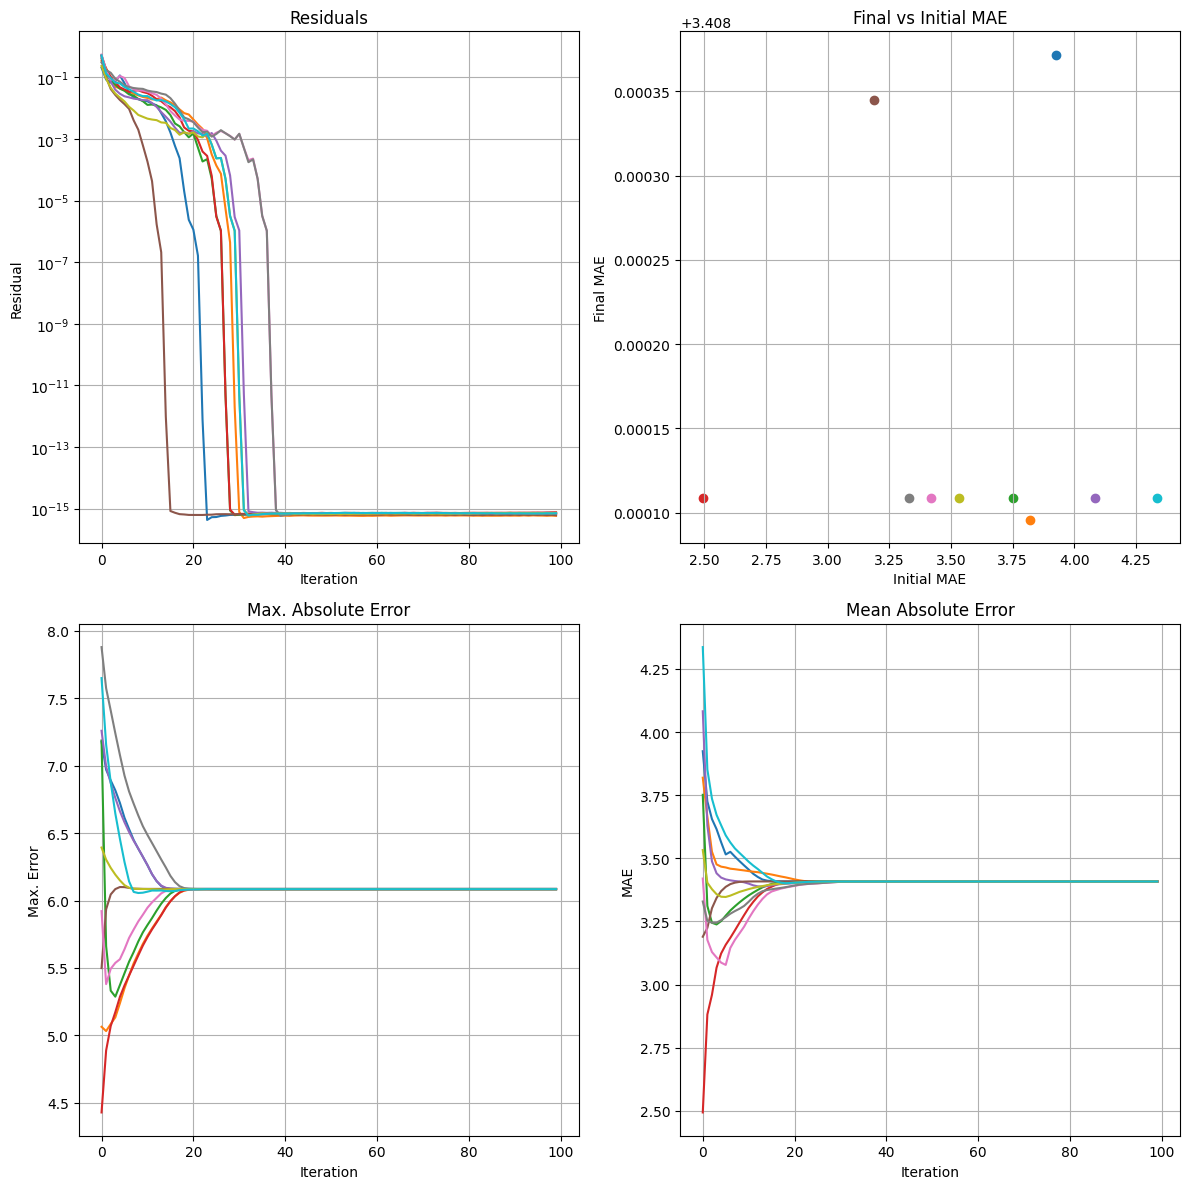

Final Transform Estimate Error: [ 1.04915193 -4.98603011  0.36568981  2.88147783 -6.0844331  -5.08216041]
Final Transform Estimate Error Filtered: [ 1.0492217  -4.98599414  0.36571743  2.88144432 -6.08402554 -5.08224828]


True Error: [ 0.00718684 -0.00414807  0.00233725  0.00426641 -0.00675707 -0.00179255]
Mean Absolute Error: [1.04915193 4.98603011 0.36568981 2.88147783 6.0844331  5.08216041]
Std. Dev. Error: [0. 0. 0. 0. 0. 0.]


In [15]:
# set number of observations and type of sampling 

np.random.seed(10)

N_observation = 1000 
observation_type = 'random' # 'random' 'local' 'time' 'all' 

initial_contact_list = []
error_list = [] 

N_trials = 1   

for i in range(N_trials):   
    # sample observations 
    if observation_type == 'random': 
        idx_observations = np.random.choice(len(real_map_data), N_observation, replace=False) 
        observation = real_map_data[idx_observations] 
        initial_contact_pose = None 
    elif observation_type == 'local': 
        idx_observation_center = np.random.choice(len(real_map_data), N_observation, replace=False) 
        initial_contact_pose = real_map_data[idx_observation_center] 
        std_perturb = 1.0 
        perturbations = initial_contact_pose + np.random.normal(0, std_perturb, (N_observation, 6)) 
        observation, idx_neighbors = nearest_neighbor(real_map_data, perturbations) # FIXME: implement a faster way to sample nearest neighbours 
    elif observation_type == 'time': 
        idx_observation_center = np.squeeze(np.random.choice(len(real_map_data), 1, replace=False)).astype(int)
        initial_contact_pose = real_map_data[idx_observation_center] 
        if idx_observation_center < N_observation: 
            idx_observation = np.linspace(0,N_observation-1,N_observation).astype(int)
        elif idx_observation_center > len(real_map_data) - N_observation: 
            idx_observation = np.linspace(len(real_map_data)-N_observation-1,len(real_map_data)-1,N_observation).astype(int)
        else:
            idx_observation = np.linspace(idx_observation_center-1,idx_observation_center+N_observation-1,N_observation).astype(int) 
        observation = real_map_data[idx_observation,:] 
    elif observation_type == 'all':
        observation = real_map_data 

    # transform observations 
    true_transform = np.random.normal(0, 5, 6) # T_R_S 
    fake_transform = np.zeros(6) # T_R_S 
    # true_transform = np.array([700,0,0,0,0,0])  
    if observation_type == 'all': 
        true_transform = np.zeros(6) # if mapping all of real data to sim, then set true transform to zero to solve for the offset between the maps 
    true_transform_invert = invert_pose6D(true_transform) # T_S_R     
    observation_transformed = apply_delta_pose(true_transform_invert, observation) # T_S_t = T_S_R @ T_R_t 
    
    # initialize solver 
    initial_guess_uncertainty = 1.5  
    N_guesses = 10 
    sim_map.set_observation(observation_transformed, true_transform) 
    # sim_map.add_noise_to_observation(0.1) 
    sim_map.set_initial_guesses(true_transform, initial_guess_uncertainty, N_guesses) 

    # solve ICP 
    sim_map.run_ICP(max_iter=100, tol=1e-18, flag_iteration_output=False, flag_plot_results=True) 
    print(f"Final Transform Estimate Error: {sim_map.transform_final_error}") 
    print(f"Final Transform Estimate Error Filtered: {sim_map.transform_final_error_filtered}") 
    print("\n")

    initial_contact_list.append(initial_contact_pose) 
    error_list.append(sim_map.transform_final_error) 

true_error = compute_delta_pose(true_transform, sim_map.transform_final_estimate) 
print(f"True Error: {true_error}") 

error_mat = np.array(error_list)     
initial_contact_pose_mat = np.squeeze(np.array(initial_contact_list))

print(f"Mean Absolute Error: {np.mean(np.abs(error_mat), axis=0)}") 
print(f"Std. Dev. Error: {np.std(error_mat, axis=0)}") 

In [ ]:
# Ablation Study: Error and Runtime vs Number of Observations 

# set number of observations and type of sampling 

if flag_ablation_num_obs: 

    N_observation_set = [100, 200, 500, 1000, 2000]      
    observation_type = 'random' # 'random' 'local' 'time' 'all' 
    N_trials = 20  
    N_guesses = 10 
    error_matrix = np.zeros((N_trials, len(N_observation_set), 6)) 
    runtime_matrix = np.zeros((N_trials, len(N_observation_set))) 

    for i in range(N_trials): 

        # print(f"Running for N_observation: {N_observation}") 
        print(f"Iteration: {i+1}/{N_trials}") 

        initial_contact_list = []
        error_list = [] 

        # use same observation center and true transform for all N_observation 
        if observation_type == 'local': 
            idx_observation_center = np.random.choice(len(real_map_data), 1, replace=False) 
        true_transform = np.random.normal(0, 5, 6) # T_R_S 
        true_transform_invert = invert_pose6D(true_transform) # T_S_R  
        initial_guess_uncertainty = 5.0 
        sim_map.set_initial_guesses(true_transform, initial_guess_uncertainty, N_guesses)

        for idx_N_obs, N_observation in enumerate(N_observation_set): 
            # sample observations 
            if observation_type == 'random': 
                idx_observations = np.random.choice(len(real_map_data), N_observation, replace=False) 
                observation = real_map_data[idx_observations] 
            elif observation_type == 'local': 
                # idx_observation_center = np.random.choice(len(real_map_data), 1, replace=False) 
                initial_contact_pose = real_map_data[idx_observation_center] 
                std_perturb = 2.0 
                perturbations = initial_contact_pose + np.random.normal(0, std_perturb, (N_observation, 6)) 
                observation, idx_neighbors = nearest_neighbor(real_map_data, perturbations) # FIXME: implement a faster way to sample nearest neighbours 
            elif observation_type == 'time': 
                idx_observation_center = np.squeeze(np.random.choice(len(real_map_data), 1, replace=False)).astype(int)
                if idx_observation_center < N_observation: 
                    idx_observation = np.linspace(0,N_observation-1,N_observation).astype(int)
                elif idx_observation_center > len(real_map_data) - N_observation: 
                    idx_observation = np.linspace(len(real_map_data)-N_observation-1,len(real_map_data)-1,N_observation).astype(int)
                else:
                    idx_observation = np.linspace(idx_observation_center-1,idx_observation_center+N_observation-1,N_observation).astype(int) 
                observation = real_map_data[idx_observation,:] 
            elif observation_type == 'all':
                observation = real_map_data 

            # transform observations 
            # true_transform = np.random.normal(0, 5, 6) # T_R_S 
            if observation_type == 'all': 
                true_transform = np.zeros(6) # if mapping all of real data to sim, then set true transform to zero to solve for the offset between the maps 
            # true_transform_invert = invert_pose6D(true_transform) # T_S_R     
            observation_transformed = apply_delta_pose(true_transform_invert, observation) # T_S_t = T_S_R @ T_R_t 
            
            start_time = time.time() 

            # initialize solver 
            # initial_guess_uncertainty = 5.0 
            sim_map.set_observation(observation_transformed, true_transform) 
            # sim_map.set_initial_guesses(true_transform, initial_guess_uncertainty, N_guesses) 

            # solve ICP 
            sim_map.run_ICP(max_iter=100, tol=1e-18, flag_iteration_output=False, flag_plot_results=False) 
            print(f"Final Transform Estimate: {sim_map.transform_final_error}") 

            error_matrix[i, idx_N_obs, :] = sim_map.transform_final_error 
            runtime_matrix[i, idx_N_obs] = time.time() - start_time  

    # plot mean and standard deviation of errors vs number of observations 
    %matplotlib inline 
    coord = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)] 
    fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 
    for i in range(6): 
        ax = axs[coord[i][0], coord[i][1]] 
        ax.errorbar(N_observation_set, np.mean(error_matrix[:,:,i], axis=0), yerr=np.std(error_matrix[:,:,i], axis=0), fmt='o') 
        ax.set_title(f'Mean Absolute Error: {pose_labels[i]}') 
        ax.set_xlabel('Number of Observations') 
        ax.set_ylabel('Mean Absolute Error') 
        ax.grid(True) 
    plt.tight_layout()
    plt.show() 

    # plot runtime vs number of observations 
    %matplotlib inline 
    fig, ax = plt.subplots(1, 1, figsize=(6, 4)) 
    ax.errorbar(N_observation_set, np.mean(runtime_matrix, axis=0), yerr=np.std(runtime_matrix, axis=0), fmt='o') 
    ax.set_title('Runtime vs Number of Observations') 
    ax.set_xlabel('Number of Observations') 
    ax.set_ylabel('Runtime (s)') 
    ax.grid(True) 
    plt.tight_layout() 
    plt.show() 


In [ ]:
# Ablation Study: Error vs Information Metrics

# set number of observations and type of sampling 

if flag_ablation_information_metrics: 

    # set number of observations and type of sampling 

    N_observation = 1000 
    observation_type = 'random' # 'random' 'local' 'time' 'all' 

    initial_contact_list = []
    error_list = [] 
    pose_std_list = [] 


    for i in range(10):   
        # sample observations 
        if observation_type == 'random': 
            idx_observations = np.random.choice(len(real_map_data), N_observation, replace=False) 
            observation = real_map_data[idx_observations] 
        elif observation_type == 'local': 
            idx_observation_center = np.random.choice(len(real_map_data), N_observation, replace=False) 
            initial_contact_pose = real_map_data[idx_observation_center] 
            std_perturb = 1.0 
            perturbations = initial_contact_pose + np.random.normal(0, std_perturb, (N_observation, 6)) 
            observation, idx_neighbors = nearest_neighbor(real_map_data, perturbations) # FIXME: implement a faster way to sample nearest neighbours 
        elif observation_type == 'time': 
            idx_observation_center = np.squeeze(np.random.choice(len(real_map_data), 1, replace=False)).astype(int)
            initial_contact_pose = real_map_data[idx_observation_center] 
            if idx_observation_center < N_observation: 
                idx_observation = np.linspace(0,N_observation-1,N_observation).astype(int)
            elif idx_observation_center > len(real_map_data) - N_observation: 
                idx_observation = np.linspace(len(real_map_data)-N_observation-1,len(real_map_data)-1,N_observation).astype(int)
            else:
                idx_observation = np.linspace(idx_observation_center-1,idx_observation_center+N_observation-1,N_observation).astype(int) 
            observation = real_map_data[idx_observation,:] 
        elif observation_type == 'all':
            observation = real_map_data 

        # transform observations 
        true_transform = np.random.normal(0, 5, 6) # T_R_S 
        if observation_type == 'all': 
            true_transform = np.zeros(6) # if mapping all of real data to sim, then set true transform to zero to solve for the offset between the maps 
        true_transform_invert = invert_pose6D(true_transform) # T_S_R     
        observation_transformed = apply_delta_pose(true_transform_invert, observation) # T_S_t = T_S_R @ T_R_t 
        pose_std_list.append(np.std(observation_transformed, axis=0)) 
        
        # initialize solver 
        initial_guess_uncertainty = 5.0 
        N_guesses = 10 
        sim_map.set_observation(observation_transformed, true_transform) 
        sim_map.set_initial_guesses(true_transform, initial_guess_uncertainty, N_guesses) 

        # solve ICP 
        sim_map.run_ICP(max_iter=100, tol=1e-18, flag_iteration_output=False, flag_plot_results=False) 
        print(f"Final Transform Estimate: {sim_map.transform_final_error}") 
        print(f"Final Transform Estimate Filtered: {sim_map.transform_final_error_filtered}") 
        print("\n")

        initial_contact_list.append(initial_contact_pose) 
        error_list.append(sim_map.transform_final_error) 

    error_mat = np.array(error_list)     
    initial_contact_pose_mat = np.squeeze(np.array(initial_contact_list))

    print(f"Mean Absolute Error: {np.mean(np.abs(error_mat), axis=0)}") 
    print(f"Std. Dev. Error: {np.std(error_mat, axis=0)}") 

    # plot error vs std deviation of poses 
    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for i in range(6): 
        ax.scatter(pose_std_list, error_mat[:,i], label=f"{pose_labels[i]}")
    ax.set_title('Error vs Pose Std. Deviation')
    ax.set_xlabel('Pose Std. Deviation')
    ax.set_ylabel('Error')
    plt.tight_layout()
    plt.show()
